In [2]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import glob
import open3d as o3d

In [3]:
image_files = sorted(glob.glob("/home/vhsiao1002/scripts/CitrusFarmDataset/output/zed2i_zed_node_left_image_rect_color/*.jpg"))
point_files = sorted(glob.glob("/home/vhsiao1002/scripts/CitrusFarmDataset/output/velodyne_points/*.pcd"))
calib_files = sorted(glob.glob("/home/vhsiao1002/scripts/CitrusFarmDataset/output/zed2i_zed_node_left_camera_info/*.txt"))
# label_files = sorted(glob.glob("data/label/*.txt"))

In [4]:
index = 1
pcd_file = point_files[index]
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)
pcd = o3d.io.read_point_cloud(pcd_file)
# pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
points = np.asarray(pcd.points)



print(pcd)
print(points)
print(points.shape)

PointCloud with 20996 points.
[[-8.6207552  -3.21459484  0.16059704]
 [-8.77045918 -3.26693392  0.49049264]
 [-9.00545025 -3.35267425  0.84070432]
 ...
 [-4.6308403  -1.46632087 -0.4249714 ]
 [-6.72977877 -2.12834978 -0.36991057]
 [-9.43446732 -2.98191953 -0.17270902]]
(20996, 3)


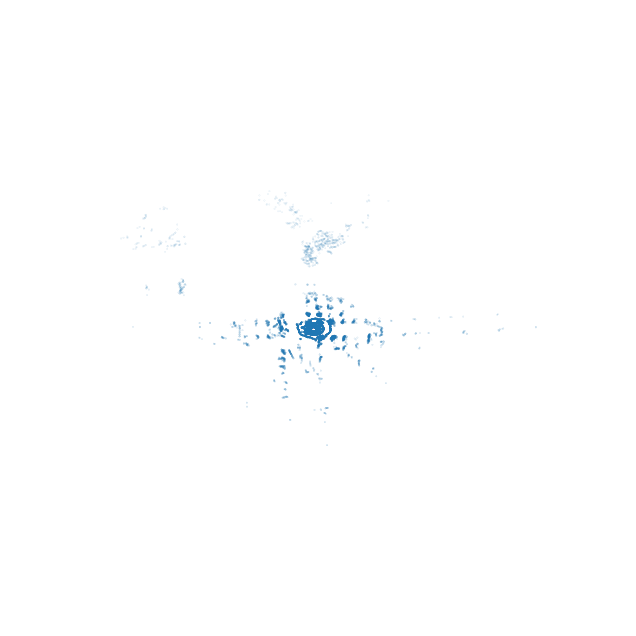

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

xs = points[:, 0]#[::20]   # Uncomment if 3d plot runs too slow, takes every 20th point
ys = points[:, 1]#[::20]
zs = points[:, 2]#[::20]

ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax.scatter(xs, ys, zs, s=0.01)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=40, azim=180)

Text(0.5, 1.0, 'Image')

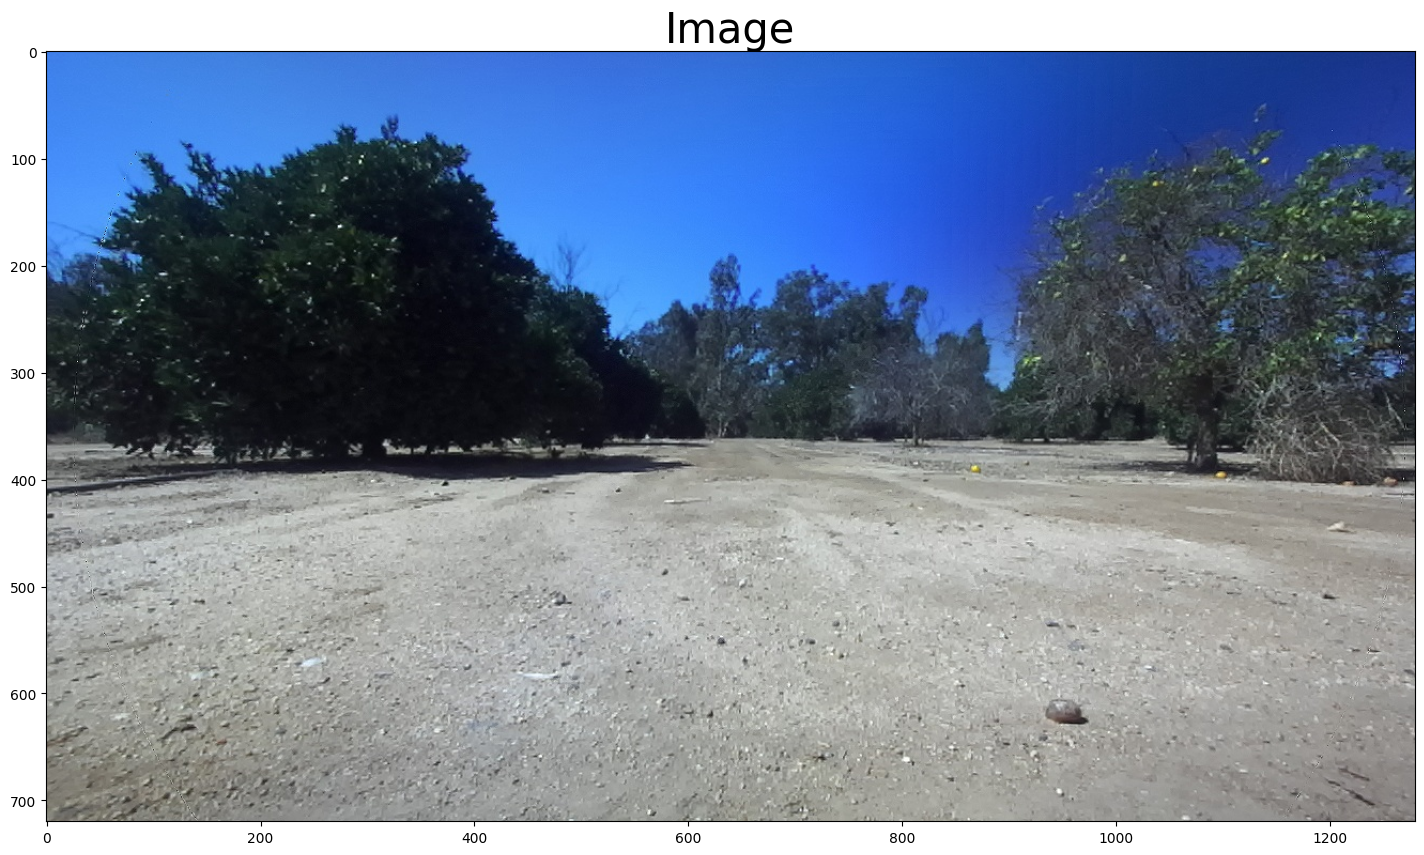

In [6]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Image', fontsize=30)

In [7]:
# o3d.visualization.draw_geometries([pcd])

In [8]:
# camera calibration handler

class CalibrationData:
    def __init__(self, calibration_file):
        self.calibration_file = calibration_file
        self.height = None
        self.width = None
        self.distortion_model = None
        self.D = None
        self.K = None
        self.R = None
        self.P = None
        self.load_calibration()

    def load_calibration(self): 
        with open(self.calibration_file, 'r') as f:
            for line in f.readlines():
                line = line.strip()
                if line.startswith('height:'):
                    self.height = int(line.split(':')[1].strip())
                elif line.startswith('width:'):
                    self.width = int(line.split(':')[1].strip())
                elif line.startswith('distortion_model:'):
                    self.distortion_model = line.split(':')[1].strip().strip('"')
                elif line.startswith('D:'):
                    self.D = self._parse_array(line.split(':', 1)[1].strip())
                elif line.startswith('K:'):
                    self.K = self._parse_matrix(line.split(':', 1)[1].strip(), 3, 3)
                elif line.startswith('R:'):
                    self.R = self._parse_matrix(line.split(':', 1)[1].strip(), 3, 3)
                elif line.startswith('P:'):
                    self.P = self._parse_matrix(line.split(':', 1)[1].strip(), 3, 4)

    def _parse_array(self, array_str):
        return np.array([float(x) for x in array_str.strip('[]').split(',')])

    def _parse_matrix(self, matrix_str, rows, cols):
        values = [float(x) for x in matrix_str.strip('[]').split(',')]
        return np.array(values).reshape((rows, cols))

    def get_intrinsic_matrix(self):
        return self.K

    def get_distortion_coeffs(self):
        return self.D
    
    def get_P_matrix(self):
        return self.P

    def get_extrinsic_matrix(self):
        extrinsic_matrix = np.hstack((self.R, np.zeros((3, 1))))
        extrinsic_matrix = np.vstack((extrinsic_matrix, [0, 0, 0, 1]))
        return extrinsic_matrix
    
    
    
calibration_data = CalibrationData(calib_files[0])
intrinsic_matrix = calibration_data.get_intrinsic_matrix()


distortion_coeffs = calibration_data.get_distortion_coeffs()
extrinsic_matrix = calibration_data.get_extrinsic_matrix()

P0 = calibration_data.get_P_matrix()


print("Intrinsic Matrix K:\n", intrinsic_matrix)
print("Distortion Coefficients D:\n", distortion_coeffs)
print("Extrinsic Matrix :\n", extrinsic_matrix)
print("P Matrix :\n", P0)


# k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(calibration_data.get_P_matrix())
# t1 = t1 / t1[3]
# print('Intrinsic Matrix:')
# print(k1)
# print('Rotation Matrix:')
# print(r1)
# print('Translation Vector:')
# print(t1.round(4))

fx = intrinsic_matrix[0, 0]
fy = intrinsic_matrix[1, 1]
cx = intrinsic_matrix[0, 2]
cy = intrinsic_matrix[1, 2]


Intrinsic Matrix K:
 [[525.03253174   0.         648.5067749 ]
 [  0.         525.03253174 357.38909912]
 [  0.           0.           1.        ]]
Distortion Coefficients D:
 [0. 0. 0. 0. 0.]
Extrinsic Matrix :
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
P Matrix :
 [[525.03253174   0.         648.5067749    0.        ]
 [  0.         525.03253174 357.38909912   0.        ]
 [  0.           0.           1.           0.        ]]


In [9]:
# lidar to camera projection matrix

# CitrusFarmDataset blackfly to stereo left camera
# Pc2b = np.array([
#         [0.02, 0.0, 0.0, -0.0663],
#         [0, -0.081, 0, 0.0956],
#         [0, 0, 0.031, -0.0161],
#         [0, 0, 0, 1]
#         ])
# pc2b = np.linalg.inv(Pc2b)

# CitrusFarmDataset blackfly to lidar
# Pb2l = np.array([
#         [0.0507, 0, 0, 0.2178],
#         [0, -0.4989, 0, 0.0049],
#         [0, 0, 0.4960, -0.0645],
#         [0, 0, 0,1 ]
#         ])

# pb2l = np.linalg.inv(Pb2l)

# lidar to camera projection matrix
# Pl2c = pc2b.dot(pb2l)
# print(Pl2c)
# pl2c = Pl2c[:3, :]
# print(pl2c)

def quaternion_rotation_matrix(Q):
    """
    https://automaticaddison.com/how-to-convert-a-quaternion-to-a-rotation-matrix/
    
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

Qz2b = [0.002, -0.0081, 0.0031, 1.0]
Qb2l = [0.5071, -0.4989, 0.4960, -0.4974]

Rz2b = quaternion_rotation_matrix(Qz2b) 
Rb2l = quaternion_rotation_matrix(Qb2l)

Tz2b = [-0.0663, 0.0956, -0.0161]
Tb2l = [0.2178, 0.0049, -0.0645]

RTz2b = np.hstack((Rz2b, np.array(Tz2b).reshape(3, 1)))
RTz2b = np.vstack((RTz2b, [0, 0, 0, 1]))
RTb2l = np.hstack((Rb2l, np.array(Tb2l).reshape(3, 1)))
RTb2l = np.vstack((RTb2l, [0, 0, 0, 1]))

print("\ncamera to blackfly Rz2b:\n", RTz2b)
print("\nblackfly to lidar Rb2l:\n", RTb2l)

RTz2b_inv = np.linalg.inv(RTz2b)
RTb2l_inv = np.linalg.inv(RTb2l)

RTl2z = np.matmul(RTz2b_inv, RTb2l_inv)

print("\ncamera to lidar Rz2l:\n", RTl2z)
# print("\n lidar to camera\n", np.linalg.inv(RTz2l))



# Tz2l = np.array(Tz2b).reshape(3,1) + np.array(Tb2l).reshape(3,1)
# print("\nTranslation Vector camera to lidar Tz2l:\n", Tz2l)
# print("Translation Vector shape\n", Tz2l.shape)

# RTz2b = np.hstack((Rz2b, np.array(Tz2b).reshape(3, 1)))
# RTb2l = np.hstack((Rb2l, np.array(Tb2l).reshape(3, 1)))

# print("RTz2b:\n", RTz2b)
# print("RTb2l:\n", RTb2l)

# RTz2b = np.vstack((RTz2b, [0, 0, 0, 1]))
# RTb2l = np.vstack((RTb2l, [0, 0, 0, 1]))

# print("Inverse RTz2b:\n", np.linalg.inv(RTz2b))
# print("Inverse RTb2l:\n", np.linalg.inv(RTb2l))


# R_t = np.matmul(np.linalg.inv(RTz2b),np.linalg.inv(RTb2l))
# print("R_t\n",R_t)
# print("R_t shape\n",R_t.shape)


#maybe i did not invert with translation vector, so rotation matrix is inverted but translation vector is not 




camera to blackfly Rz2b:
 [[-0.99986078 -0.00405022 -0.0161876  -0.0663    ]
 [ 0.00394978 -0.99997278  0.0062324   0.0956    ]
 [-0.0162124   0.0061676   1.000008   -0.0161    ]
 [ 0.          0.          0.          1.        ]]

blackfly to lidar Rb2l:
 [[ 0.01210324  0.00955428  0.99934892  0.2178    ]
 [-0.99937188  0.00633282  0.01256358  0.0049    ]
 [-0.00673748 -0.99940518  0.00911434 -0.0645    ]
 [ 0.          0.          0.          1.        ]]

camera to lidar Rz2l:
 [[-0.02881299  1.00012605  0.0021098  -0.06541842]
 [-0.00292012 -0.00272785  1.00052274  0.16061124]
 [ 0.99995496  0.02828189  0.00350362 -0.20327655]
 [ 0.          0.          0.          1.        ]]


pointcloud shape (20996, 3)


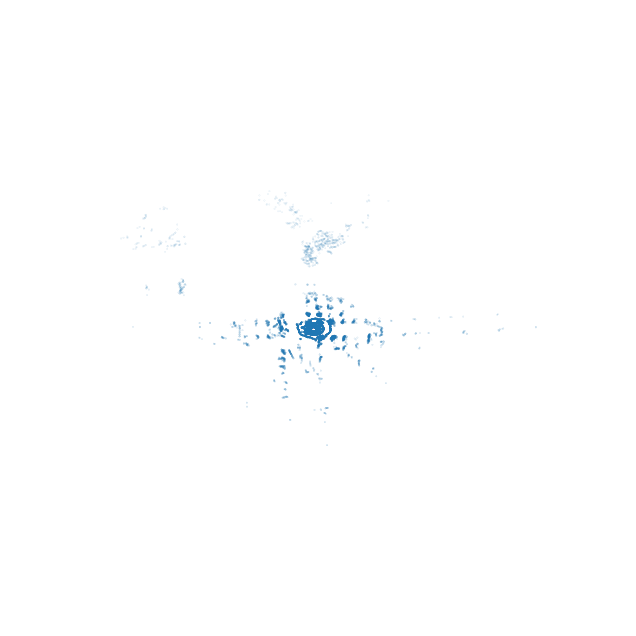

In [10]:
pointcloud = points
print("pointcloud shape",pointcloud.shape)

# Visualizing a lidar pointcloud with matplotlib.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

xs = pointcloud[:, 0]#[::20]   # Uncomment if 3d plot runs too slow, takes every 20th point
ys = pointcloud[:, 1]#[::20]
zs = pointcloud[:, 2]#[::20]

ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax.scatter(xs, ys, zs, s=0.01)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=40, azim=180)

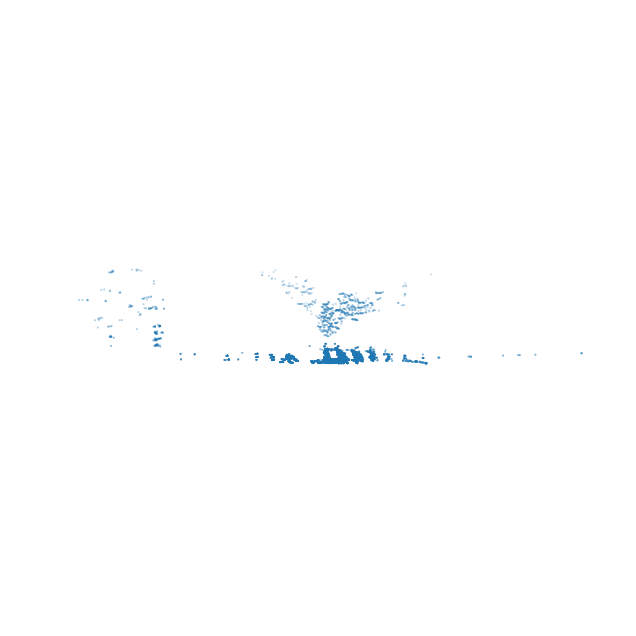

In [11]:

# ignore anything with a X value less than or equal to zero
pointcloud = pointcloud[pointcloud[:, 0] > 0]

# Visualizing a lidar pointcloud with matplotlib.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

xs = pointcloud[:, 0]#[::10]   # Uncomment if 3d plot runs too slow, takes every 10th point
ys = pointcloud[:, 1]#[::10]
zs = pointcloud[:, 2]#[::10]

ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
# ax.scatter(xs, ys, s=0.1)
ax.scatter(xs, ys, zs, s=0.1)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=10, azim=180)

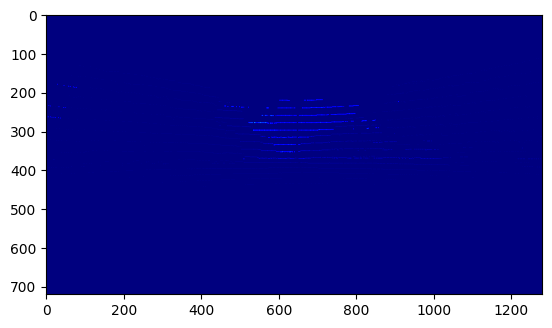

In [12]:
# # https://github.com/FoamoftheSea/KITTI_visual_odometry/blob/main/KITTI_visual_odometry.ipynb

# stereo camera resolution
imwidth = 1280
imheight = 720

# coordinates homogeneous for tranformation into the camera coordinate frame
pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])   


# Transform pointcloud into camera coordinate frame
cam_xyz = np.matmul(RTl2z, pointcloud.T) 
# cam_xyz = cam_xyz + Tz2l

cam_xyz1 = cam_xyz

# Add row of ones to make our 3D coordinates on plane homogeneous for dotting with P0
# cam_xyz2 = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1]).reshape((1,-1))])


#############
# Ignore any points behind the camera (Redundancy)
cam_xyz = cam_xyz[:, cam_xyz[2] > 0]

# Extract the Z row which is the depth from camera
depth = cam_xyz[2].copy() 
# print(depth.shape)
# print(depth)


# cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
# print("cam_xyz shape",cam_xyz.shape)

# Get pixel coordinates of X, Y, Z points in camera coordinate frame
# print("K0 shape", intrinsic_matrix.shape)
# print("K0\n", intrinsic_matrix)
# print("cam_xyz shape",cam_xyz.shape)

# projection1 = np.matmul(extrinsic_matrix,cam_xyz)
# print("projection 1\n",projection1)

# projection2 = np.matmul(intrinsic_matrix,projection1[:3,:])
# print("projection 2\n",projection2)

projection = np.matmul(P0,cam_xyz)
# print("projection 2\n",projection3)

projection3 = projection

# print("P0 shape", P0.shape)
# projection2 = np.matmul(P0,cam_xyz2)

# projectionz = projection[2]
# projection2 = projection/projectionz
# depth1 = projection[2]

# Project coordinates in camera frame to flat plane at Z=1 by dividing by Z
projection /= projection[2]
# print(projection.T)
# print("projection shape:",projection.shape)



# Turn pixels into integers for indexing
projectionT = (projection.T)[:, :2]
pixel_coordinates = projectionT.round(0).astype(int)
# print(pixel_coordinates)



# Limit pixel coordinates considered to those that fit on the image plane
indices = np.where((pixel_coordinates[:, 0] < imwidth)
                    & (pixel_coordinates[:, 0] >= 0)
                    & (pixel_coordinates[:, 1] < imheight)
                    & (pixel_coordinates[:, 1] >= 0)
                    )


pixel_coordinates = pixel_coordinates[indices]

# Flip horizontally (invert y-coordinates)
pixel_coordinates[:, 1] = imheight - pixel_coordinates[:, 1]
# Flip vertically (invert x-coordinates)
pixel_coordinates[:, 0] = imwidth - pixel_coordinates[:, 0]

# depth = depth[indices[:-1]]
depth = depth[indices]


# Establish empty render image, then fill with the depths of each point
render = np.zeros((imheight, imwidth))
for j, (u, v) in enumerate(pixel_coordinates):
    if u >= imwidth or u < 0:
        continue
    if v >= imheight or v < 0:
        continue
    render[v, u] = depth[j]
    
# Fill zero values with large distance so they will be ignored. (Using max value)
# render[render == 0.0] = np.max(render)

plt.imshow(render, cmap='jet')
# plt.imshow(render)

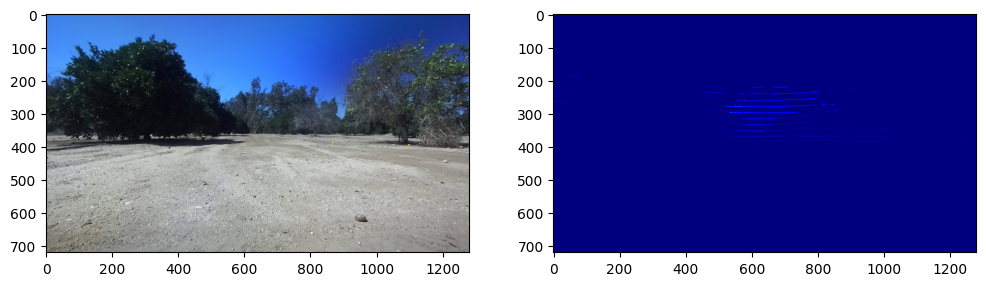

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(image)
ax2.imshow(render, cmap='jet')
# ax2.imshow(render)

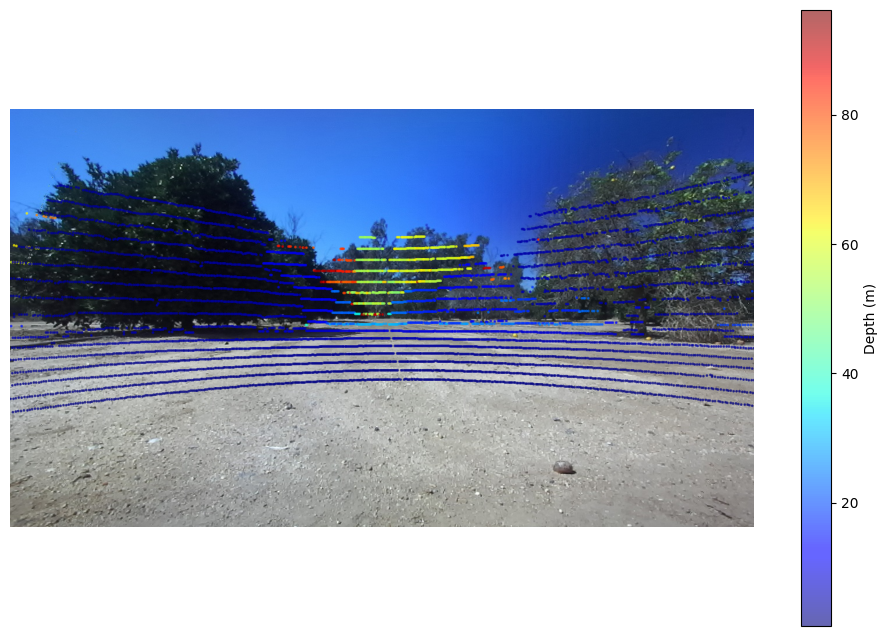

In [14]:
# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Display the image
ax.imshow(image)

# Plot the flipped projected points
sc = ax.scatter(pixel_coordinates[:, 0], pixel_coordinates[:, 1], s=1,c=depth, cmap='jet', alpha = 0.6)


# Add colorbar to show depth scale
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Depth (m)')

# Optionally set axis limits if needed
ax.set_xlim([0, imwidth])
ax.set_ylim([imheight, 0])  # Invert y-axis for proper image display

# Hide the axes
ax.axis('off')

# Show the plot
plt.show()

In [15]:
# import cv2
import nerfstudio
# from matplotlib import cm
from nerfstudio.cameras.cameras import Cameras
import torch

In [16]:
#Camera object
RTl2z_tensor = torch.tensor(RTl2z[:3,:4], dtype=torch.float32)
camera_obj = Cameras(RTl2z_tensor, fx, fy, cx, cy, width=1280, height=720)

#Depth tensor
depth_img = render
depth_tensor = torch.from_numpy((depth_img[:, :, np.newaxis] / 1000).astype(np.float32))
depth_flatten = depth_tensor.flatten(0, 1)

#image tensor
rgb = torch.from_numpy((image / 255.0).astype(np.float32))
rgb = rgb.flatten(0, 1)

#generate rays
idx = torch.zeros([1, 1], dtype=torch.long)
ray_bundle = camera_obj.generate_rays(idx, disable_distortion=True)


#origins and directions
origins = ray_bundle.origins.flatten(0, 2)
directions = ray_bundle.directions.flatten(0, 2)
shape = origins.size()
shape_list = list(shape)

#new points
new_points = torch.ones(shape_list)
new_points = directions * depth_flatten
# new_points = origins + new_points


#new colored pointcloud
ray_points = new_points.double().cpu().numpy()
ray_colors = rgb.double().cpu().numpy()

pcd_rays = o3d.geometry.PointCloud()
pcd_rays.points = o3d.utility.Vector3dVector(ray_points)
pcd_rays.colors = o3d.utility.Vector3dVector(ray_colors)


#show the coloured pointcloud
o3d.visualization.draw_geometries([pcd_rays], window_name="Point Cloud Visualization")

# pcd.set_background([0,0,0,0], image=None)

DEPTH TO POINTCLOUD

In [17]:
rgb_image_files = sorted(glob.glob("/home/vhsiao1002/Data/nerf_data/images/*.png"))
depth_image_files = sorted(glob.glob("/home/vhsiao1002/Data/nerf_data/depth/*.png"))

index = 50

rgb = cv2.cvtColor(cv2.imread(rgb_image_files[index]), cv2.COLOR_BGR2GRAY)
depth = o3d.io.read_image(depth_image_files[index])

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(rgb), o3d.geometry.Image(depth))

print(rgbd)


d2pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd,o3d.camera.PinholeCameraIntrinsic(width=imwidth, height=imheight, fx=fx, fy=fy, cx=cx, cy=cy))

d2pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

o3d.visualization.draw_geometries([d2pcd], window_name="Point Cloud Visualization")

RGBDImage of size 
Color image : 1280x720, with 1 channels.
Depth image : 1280x720, with 1 channels.
Use numpy.asarray to access buffer data.


SAVE PCD AS PLY FILE

In [18]:
# #save pointcloud as ply file

# #path to data
# data_path = "/home/vhsiao1002/Data/"

# #name of the dataset
# dataset_name = "nerf_data"


# pcd_files = sorted(glob.glob("/home/vhsiao1002/scripts/CitrusFarmDataset/output/velodyne_points/*.pcd"))

# for index_pcd, pcd_file in enumerate(pcd_files):
#     pcd2ply = o3d.io.read_point_cloud(pcd_file)
#     point_cloud_path = "" +data_path +dataset_name+"/point_cloud/point_cloud_"+str(index_pcd)+".ply"
#     o3d.io.write_point_cloud(point_cloud_path, pcd2ply, write_ascii=True, print_progress=True)

# print("done converting pcd to ply")


RENAME POINTCLOUD

In [19]:
# #rename pointcloud
# # import os

# #path to data
# data_path = "/home/vhsiao1002/Data/"

# #name of the dataset
# dataset_name = "nerf_data"

# pcd_files_rename = sorted(glob.glob("/home/vhsiao1002/scripts/CitrusFarmDataset/output/velodyne_points/*.pcd"))
# print(len(pcd_files_rename))

# for index_pcd_rename, pcd_file in enumerate(pcd_files_rename):
#     pcd_rename = o3d.io.read_point_cloud(pcd_file)
#     point_cloud_path = "" +data_path +dataset_name+"/velodyne_points/point_cloud_"+str(index_pcd_rename)+".pcd"
#     o3d.io.write_point_cloud(point_cloud_path,pcd_rename, write_ascii=True, print_progress=True)
    
# print("done renaming pcd files")

INVERT MASK 

In [20]:
# #invert mask image
# mask_files = sorted(glob.glob("/home/vhsiao1002/scripts/CitrusFarmDataset/segmentation/*.png"))

# for index_mask, mask_file in enumerate(mask_files):
#     mask = mask = cv2.imread(mask_file, cv2.COLOR_BGR2GRAY)
#     # print(mask.shape)
#     mask_path = "/home/vhsiao1002/scripts/CitrusFarmDataset/masks/mask_"+str(index_mask)+".png"
#     # mask_path = "" +data_path +dataset_name+"/masks/mask_"+str(index_mask)+".png"
    
#     # mask = cv2.bitwise_not(mask)
#     for i in range (720):
#         for j in range(1280):
#             if mask[i][j] == 0:
#                 mask[i][j] = 255
#             elif mask[i][j] == 255:
#                 mask[i][j] = 0
    
#     cv2.imwrite(mask_path, mask)
    
# print("done inverting mask image")

MAKE TOP FEW ROWS OF IMAGE BLACK

In [21]:
# #make top few rows of image black
# # change_name =
# changed_files = sorted(glob.glob("/home/vhsiao1002/Data/nerf_data/masks/*.png"))
# num_rows = 5

# for index_change, change_file in enumerate(changed_files):
#     change = cv2.imread(change_file, cv2.COLOR_BGR2GRAY)
#     change_path = "/home/vhsiao1002/Data/nerf_data/masks/mask_"+str(index_change)+".png"
    
#     for i in range (0, num_rows):
#         for j in range(1280):
#             change[i][j] = 0
    
#     cv2.imwrite(change_path, change)
    
# print("done changing mask image")

CHECK POINTCLOUD

In [61]:

from pathlib import Path

index = 1

#path to data
data_path = "/home/vhsiao1002/Data/"

#name of the dataset
dataset_name = "nerf_data"

# point_cloud_path = "" +data_path +dataset_name+"/point_cloud/*.pcd"
# point_cloud_files = sorted(glob.glob(point_cloud_path))
# point_cloud_file = point_cloud_files[index]

point_cloud_path = "" +data_path +dataset_name+"/point_cloud/point_cloud_"+str(index)+".ply"


pose_path = "" +data_path +dataset_name+"/poses/*.txt"
pose_files = sorted(glob.glob(pose_path))

pcd_check = o3d.io.read_point_cloud(point_cloud_path)

o3d.visualization.draw_geometries([pcd_check], window_name="Point Cloud check")


def _load_3D_points(ply_file_path: Path, transform_matrix: torch.Tensor, scale_factor: float):
        """Loads point clouds positions and colors from .ply

        Args:
            ply_file_path: Path to .ply file
            transform_matrix: Matrix to transform world coordinates
            scale_factor: How much to scale the camera origins by.

        Returns:
            A dictionary of points: points3D_xyz and colors: points3D_rgb
        """
        # import open3d as o3d  # Importing open3d is slow, so we only do it if we need it.

        pcd = o3d.io.read_point_cloud(str(ply_file_path))

        # if no points found don't read in an initial point cloud
        if len(pcd.points) == 0:
            return None

        points3D = torch.from_numpy(np.asarray(pcd.points, dtype=np.float32))
        points3D = (
            torch.cat(
                (
                    points3D,
                    torch.ones_like(points3D[..., :1]),
                ),
                -1,
            )
            @ transform_matrix.T
        )
        points3D *= scale_factor
        points3D_rgb = torch.from_numpy((np.asarray(pcd.colors) * 255).astype(np.uint8))

        out = {
            "points3D_xyz": points3D,
            "points3D_rgb": points3D_rgb,
        }
        return out
    
    
pc_out = _load_3D_points(ply_file_path=point_cloud_path, transform_matrix=RTl2z_tensor, scale_factor = 1.0)

#convert pc_out to numpy array
pc_xyz_out = pc_out["points3D_xyz"].cpu().numpy()

pcd_out = o3d.geometry.PointCloud()
pcd_out.points = o3d.utility.Vector3dVector(pc_xyz_out)

o3d.visualization.draw_geometries([pcd_out], window_name="Point Cloud out")